1) Setup + datos

In [1]:
%pip install -q scikit-learn joblib matplotlib

from pyspark.sql import SparkSession
import numpy as np, pandas as pd

spark = (SparkSession.builder.master("local[*]").appName("dl-mlp").getOrCreate())
pdf = spark.read.parquet("/data/processed/employee_attrition.parquet").toPandas()

y = pdf["attrition_label"].astype(int)
drop_cols = ["attrition_label","Attrition","EmployeeNumber","EmployeeCount","StandardHours","Over18"]
X = pdf.drop(columns=[c for c in drop_cols if c in pdf.columns], errors="ignore")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
len(X_train), len(X_test), sum(y_train), sum(y_test)


Note: you may need to restart the kernel to use updated packages.


(1176, 294, 190, 47)

2) Pipeline MLP + métricas

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

preproc = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

mlp = MLPClassifier(
    hidden_layer_sizes=(64,32),
    activation="relu",
    max_iter=120,
    early_stopping=True,
    random_state=42
)

pipe_mlp = Pipeline([("prep", preproc), ("clf", mlp)])
pipe_mlp.fit(X_train, y_train)

proba = pipe_mlp.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

res_mlp = {
    "accuracy": float(accuracy_score(y_test, pred)),
    "f1": float(f1_score(y_test, pred)),
    "roc_auc": float(roc_auc_score(y_test, proba)),
    "pr_auc": float(average_precision_score(y_test, proba)),
}
res_mlp


{'accuracy': 0.8707482993197279,
 'f1': 0.4242424242424243,
 'roc_auc': 0.8154018433973641,
 'pr_auc': 0.5886864316733833}

3) Tuning de umbral 

In [3]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np, json, os

prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = [f1_score(y_test, (proba >= t).astype(int)) for t in thr]
best_idx = int(np.argmax(f1s))
best_thr_mlp = float(thr[best_idx])
best_f1_mlp  = float(f1s[best_idx])
print("Mejor umbral MLP por F1:", best_thr_mlp, "F1:", best_f1_mlp)

os.makedirs("/output/metrics", exist_ok=True)
with open("/output/metrics/threshold_tuning_mlp.json","w") as f:
    json.dump({"best_threshold_by_f1": best_thr_mlp, "best_f1": best_f1_mlp}, f, indent=2)


Mejor umbral MLP por F1: 0.2254355869561782 F1: 0.5346534653465347


4) Guardar modelo y comparativa con baseline

In [4]:
import os, json, joblib

# Guarda modelo + umbral
os.makedirs("/output/models", exist_ok=True)
joblib.dump({"model": pipe_mlp, "threshold": best_thr_mlp}, "/output/models/mlp_sklearn.pkl")

# Une métricas con el baseline
with open("/output/metrics/model_baseline.json") as f:
    base = json.load(f)
base["mlp_sklearn"] = {k: res_mlp[k] for k in ["accuracy","f1","roc_auc"]}

with open("/output/metrics/model_compare.json","w") as f:
    json.dump(base, f, indent=2)

print("Guardado /output/models/mlp_sklearn.pkl y /output/metrics/model_compare.json")


Guardado /output/models/mlp_sklearn.pkl y /output/metrics/model_compare.json


 5) Confusión y ROC @umbral MLP

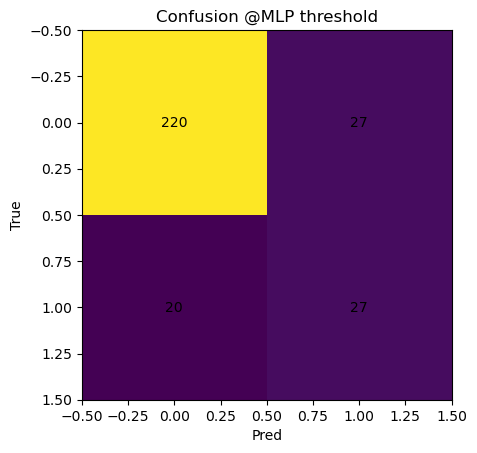

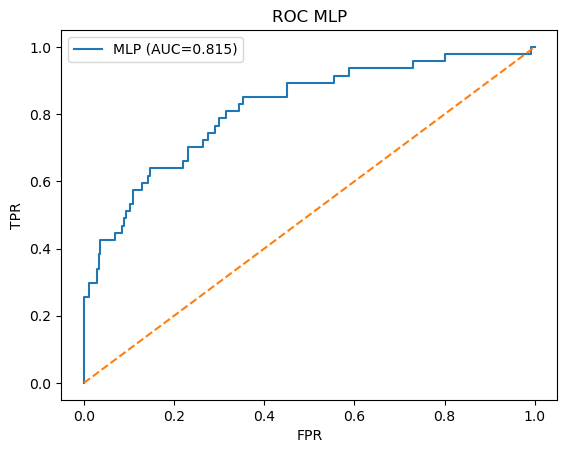

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

pred_best = (proba >= best_thr_mlp).astype(int)
cm = confusion_matrix(y_test, pred_best)

plt.figure()
plt.imshow(cm)
plt.title("Confusion @MLP threshold")
plt.xlabel("Pred"); plt.ylabel("True")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()

fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"MLP (AUC={roc_auc_score(y_test, proba):.3f})")
plt.plot([0,1],[0,1],"--")
plt.title("ROC MLP"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.show()


 6) Gráfico de comparativa global

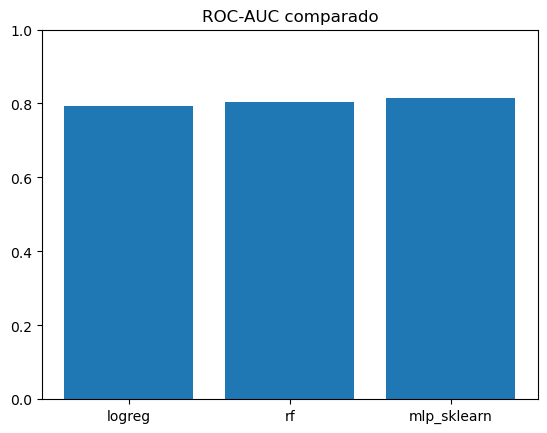

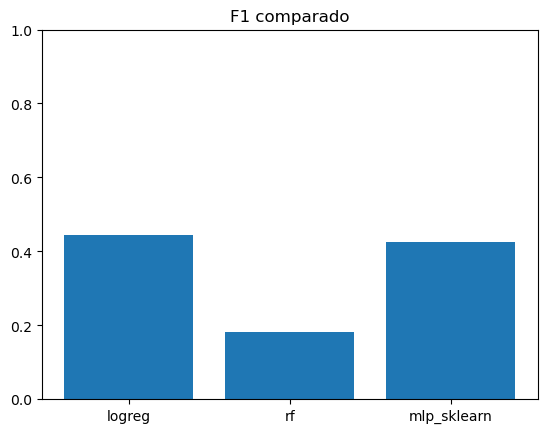

Guardado: /output/plots/model_compare_{auc,f1}.png


In [6]:
import json, matplotlib.pyplot as plt

with open("/output/metrics/model_compare.json") as f:
    comp = json.load(f)

labels = list(comp.keys())
auc_vals = [comp[m]["roc_auc"] for m in labels]
f1_vals  = [comp[m]["f1"] for m in labels]

plt.figure()
plt.bar(labels, auc_vals); plt.ylim(0,1); plt.title("ROC-AUC comparado")
plt.savefig("/output/plots/model_compare_auc.png"); plt.show()

plt.figure()
plt.bar(labels, f1_vals); plt.ylim(0,1); plt.title("F1 comparado")
plt.savefig("/output/plots/model_compare_f1.png"); plt.show()

print("Guardado: /output/plots/model_compare_{auc,f1}.png")
